# Molecular Entities (Genes / Proteins, Variants) in GGPONC

## Prepare Custom Tokenization Rules

In [1]:
import spacy

nlp = spacy.load('de_dep_news_trf')
# Make sure compounds ("BRAF-Mutation") are tokenized
infixes = nlp.Defaults.infixes + [r'([-+/–\(\)])']
nlp.tokenizer.infix_finditer = spacy.util.compile_infix_regex(infixes).finditer

In [2]:
# Store for training NER model using the same tokenizer
nlp.to_disk("spacy_ner/molecular_tokenizer")

## Model Training

Place the contents of `molecular_2024_04_03` into the `data` folder, then run:

- `cd spacy_ner`
- `./run_training.sh <CUDA DEVICE> ../data/molecular_2024_04_03 GerMedBERT/medbert-512 spancat_molecular`

# Load Dataset

In [3]:
from pathlib import Path
data_path = Path('data/molecular_2024_04_03/')

In [4]:
SPLITS = ['train', 'validation', 'test']

In [5]:
from xmen.data import from_spacy
from spacy.tokens import DocBin

docs = {}

for split in SPLITS:
    db = DocBin(store_user_data=True).from_disk(data_path / f'{split}.spacy')
    docs[split] = list(db.get_docs(nlp.vocab))

In [6]:
all_docs = sum(docs.values(), [])

In [7]:
def get_genes(docs):
    return [e.text for d in docs for e in d.spans['entities'] if e.label_ == 'Gene or Protein']

def get_variants(docs):
    return [e.text for d in docs for e in d.spans['entities'] if e.label_ == 'Variant']

In [8]:
for split in SPLITS:
    d = docs[split]
    print(split, 'Docs', len(d), '#Genes', len(get_genes(d)), '#Variants', len(get_variants(d)))
print('Total', 'Docs', len(all_docs), '#Genes', len(get_genes(all_docs)), '#Variants', len(get_variants(all_docs)))

train Docs 239 #Genes 1766 #Variants 633
validation Docs 52 #Genes 407 #Variants 110
test Docs 52 #Genes 377 #Variants 106
Total Docs 343 #Genes 2550 #Variants 849


## Types / Unique Names

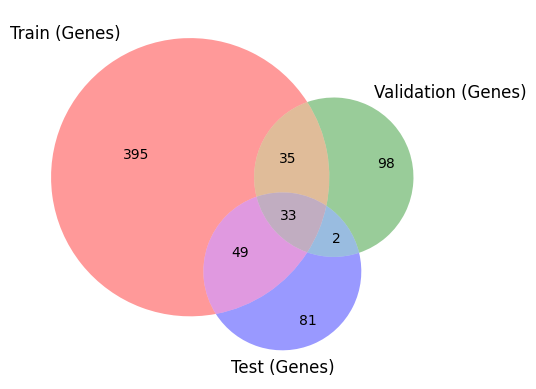

In [9]:
from matplotlib_venn import venn3

train_genes = set(get_genes(docs['train']))
val_genes = set(get_genes(docs['validation']))
test_genes = set(get_genes(docs['test']))

venn3([train_genes, val_genes, test_genes], ['Train (Genes)', 'Validation (Genes)', 'Test (Genes)'])

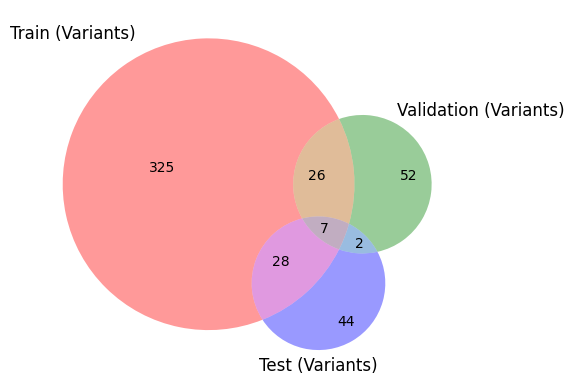

In [10]:
train_vars = set(get_variants(docs['train']))
val_vars = set(get_variants(docs['validation']))
test_vars = set(get_variants(docs['test']))

from matplotlib_venn import venn3
venn3([train_vars, val_vars, test_vars], ['Train (Variants)', 'Validation (Variants)', 'Test (Variants)'])

## Show annotation example

In [11]:
from spacy import displacy
def show(d):
    displacy.render(d, style='span', options={'spans_key' : 'entities'})
show(all_docs[13])

In [12]:
import pandas as pd
pd.Series([len(g.split(' ')) for g in get_genes(all_docs)]).value_counts()

1    2419
2      91
3      24
4      10
5       6
Name: count, dtype: int64

In [13]:
pd.Series([len(g.split(' ')) for g in get_variants(all_docs)]).value_counts()

1     435
2     156
3     151
4      39
5      37
6      11
7       9
8       8
12      2
11      1
Name: count, dtype: int64

# Performance Evaluation

In [14]:
from tqdm.auto import tqdm
from xmen.data import from_spacy
from xmen.evaluation import evaluate, error_analysis

In [15]:
import spacy
from spacy_ner import chunk_and_ngram_suggester
cp = '2024-05-23_14-52-36-cuda-1' # Replace with your training directory
model = spacy.load(f'spacy_ner/training/{cp}/model-best/')

In [16]:
test_docs = docs['test']

In [17]:
gt_test = from_spacy(test_docs, span_key='entities', doc_id_key='file')

In [18]:
pred_test = list(model.pipe((t.text for t in tqdm(test_docs)), batch_size=16))

  0%|          | 0/52 [00:00<?, ?it/s]

In [19]:
for t, pt in zip(test_docs, pred_test):
    pt.user_data['file'] = t.user_data['file']

In [20]:
pred_test_ds = from_spacy(pred_test, span_key='entities', doc_id_key='file')

In [21]:
evaluate(gt_test, pred_test_ds, ner_only=True, metrics=['strict', 'partial'])

{'strict': {'precision': 0.8810679611650486,
  'recall': 0.7515527950310559,
  'fscore': 0.8111731843575418,
  'ptp': 363,
  'fp': 49,
  'rtp': 363,
  'fn': 120,
  'n_docs_system': 52,
  'n_annos_system': 412,
  'n_docs_gold': 52,
  'n_annos_gold': 483},
 'partial': {'precision': 0.927035914087167,
  'recall': 0.7785957195294001,
  'fscore': 0.8463564820591893,
  'ptp': 381.9387966039128,
  'fp': 30.061203396087194,
  'rtp': 376.06173253270026,
  'fn': 106.93826746729974,
  'n_docs_system': 52,
  'n_annos_system': 412,
  'n_docs_gold': 52,
  'n_annos_gold': 483}}

In [22]:
ea = error_analysis(gt_test, pred_test_ds, tasks=['ner'])
ea.ner_match_type.value_counts()

ner_match_type
tp     363
fn      92
fp      23
be      22
lbe     11
Name: count, dtype: int64

In [23]:
ea.query('ner_match_type == "fn"')

,_word_len,_abbrev,gt_start,gt_end,gt_text,gold_type,pred_start,pred_end,pred_text,pred_type,ner_match_type,corpus_id,document_id
10,1.0,False,701.0,718.0,[18q-Alleelverlust],Variant,NaN,NaN,None,None,fn,None,02_kolorektales-karzinom_0327.txt
13,1.0,False,1414.0,1441.0,[Mikrosatelliteninstabilität],Variant,NaN,NaN,None,None,fn,None,02_kolorektales-karzinom_0327.txt
15,3.0,False,1621.0,1644.0,[Mismatch Repair Protein],Gene or Protein,NaN,NaN,None,None,fn,None,02_kolorektales-karzinom_0327.txt
16,1.0,True,1646.0,1650.0,[MMRP],Gene or Protein,NaN,NaN,None,None,fn,None,02_kolorektales-karzinom_0327.txt
17,1.0,True,1732.0,1736.0,[MMRP],Gene or Protein,NaN,NaN,None,None,fn,None,02_kolorektales-karzinom_0327.txt
...,...,...,...,...,...,...,...,...,...,...,...,...,...
479,1.0,False,20458.0,20463.0,[MnSOD],Gene or Protein,NaN,NaN,None,None,fn,None,28_komplementaermedizin_0272.txt
480,1.0,True,20582.0,20587.0,[PSADT],Gene or Protein,NaN,NaN,None,None,fn,None,28_komplementaermedizin_0272.txt
481,1.0,True,20729.0,20734.0,[PSADT],Gene or Protein,NaN,NaN,None,None,fn,None,28_komplementaermedizin_0272.txt
495,7.0,False,292.0,357.0,[genetisches Rearrangement der Anaplastischen ...,Variant,NaN,NaN,None,None,fn,None,29_adulte-weichgewebesarkome_0393.txt


In [24]:
mol_path_1 = """
Im Panel werden folgende Gene ganz oder teilweise untersucht:
 
 A) Amplicon-basierter Nachweis von DNA-Varianten in Mutationshotspots in folgenden Genen:
 AKT1, AKT2, AKT3, ALK, AR, ARAF, AXL, BRAF, BTK, CBL, CCND1, CDK4, CDK6, CHEK2, CSF1R, CTNNB1, DDR2, EGFR, ERBB3, ERBB2, ERBB4, ERCC2, ESR1, EZH2, FGFR1, FGFR2, FGFR3, FGFR4, FLT3, FOXL2, GATA2, GNA11, GNAQ, GNAS, H3F3A, HIST1H3B, HNF1A, HRAS, IDH1, IDH2, JAK1, JAK2, JAK3, KDR, KIT, KNSTRN, KRAS, MAGOH, MAP2K1, MAP2K2, MAP2K4, MAPK1, MAX, MDM4, MED12, MET, MTOR, MYC, MYCN, MYD88, NFE2L2, NRAS, NTRK1, NTRK2, PDGFRA, PDGFRB, PIK3CA, PIK3CB, PPP2R1A, PTPN11, RAC1, RAF1, RET, RHEB, RHOA, ROS1, SF3B1, SMAD4, SMO, SPOP, SRC, STAT3, TERT, TOP1, U2AF1, XPO1
 
 B) Amplicon-basierter Nachweis von DNA-Varianten in der kompletten kodierenden Sequenz in folgenden Genen:
 ARID1A, ATM, ATR, ATRX, BAP1, BRCA1, BRCA2, CDK12, CDKN1B, CDKN2A, CDKN2B, CHEK1, CREBBP, FANCA, FANCD2, FANCI, FBXW7, MLH1, MRE11A, MSH2, MSH6, NBN, NF1, NF2, NOTCH1, NOTCH2, NOTCH3, PALB2, PIK3R1, PMS2, POLE, PTCH1, PTEN, RAD50, RAD51, RAD51B, RAD51C, RAD51D, RB1, RNF43, SETD2, SLX4, SMARCA4, SMARCB1, STK11, TP53, TSC1, TSC2
 
 C) Amplicon-basierter  Nachweis von Änderungen der Genkopienzahl in folgenden Genen:
 AKT1, AKT2, AKT3, ALK, AR, AXL, BRAF, CCND1, CCND2, CCND3, CCNE1, CDK2, CDK4, CDK6, CDKN2A, CDKN2B, EGFR, ERBB2, ESR1, FGF19, FGF3, FGFR1, FGFR2, FGFR3, FGFR4, FLT3, IGF1R, KIT, KRAS, MDM2, MDM4, MET, MYC, MYCL, MYCN, NTRK1, NTRK2, NTRK3, PDGFRA, PDGFRB, PIK3CA, PIK3CB, PPARG, RICTOR, TERT, TSC1, TSC2
 Pathologisch-anatomische Begutachtung:
 I. Eine Gallenblase mit mäßiger chronischer und florider Entzündung.
"""

In [25]:
show(model(mol_path_1))

In [26]:
mol_path_2 = """
HER2-Statusbestimmung:
Es kamen für den Genlocus 17q12 sowie für die Centromerregion des Chromosoms 17 (CEP17) spezifische Sonden zum Einsatz. 
Es wurden > 50 Tumorzellkerne ausgezählt. 
Es zeigten sich ein bis drei Signale für 17q12 (HER2/neu) und ein bis drei Signale für CEP17. Die 17q12/CEP17 Ratio lag bei < 2,0:1.

Folgende Varianten wurden nachgewiesen:
 
Gen Variante    Frequenz    Lesetiefe   Bewertung

KRAS    chr12:25398284:NM_033360.4:Exon2:c.35G>T:p.G12V 8,7%    2.235 AMP Tier I

Aktivierende Hotspotmutation

JAK2    chr9:5073770:NM_004972.4:Exon14:c.1849G>T:p.V617F   20,4%   831 AMP Tier I

Aktivierende Hotspotmutation, möglicherweise aus den Blutgefäßen im Tumor. Ist eine P.vera oder MPN bekannt?
 
Kopienzahlveränderungen:    KEIN Anhalt für das Vorliegen einer Kopienzahlveränderung eines der aufgeführten Gene
"""

show(model(mol_path_2))